**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

**Note**: You may find little differences between the code outputs in the book and in these Jupyter notebooks: these slight differences are mostly due to the random nature of many training algorithms: although I have tried to make these notebooks' outputs as constant as possible, it is impossible to guarantee that they will produce the exact same output on every platform. Also, some data structures (such as dictionaries) do not preserve the item order. Finally, I fixed a few minor bugs (I added notes next to the concerned cells) which lead to slightly different results, without changing the ideas presented in the book.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = ""
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
IMAGES_PATH = PROJECT_ROOT_DIR

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# House prices

Look at the Big Picture
Welcome to Machine Learning Housing Corporation! The first task you are asked to
perform is to build a model of housing prices in California using the California census
data (altered for teaching purposes). This data has metrics such as the population, median income, median housing
price, and so on for each block group in California. Block groups are the smallest
geographical unit for which the US Census Bureau publishes sample data (a block
group typically has a population of 600 to 3,000 people). We will just call them “districts”
for short.
Your model should learn from this data and be able to predict the median housing
price in any district, given all the other metrics.

Here are the main steps you will go through:

1. Look at the big picture and frame the problem
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.



# Frame the problem

What are the business objectives?

What is the right metrics? (RMSE for HP-> Regression)

What are the downstream modules?
In ML we have __pipelines__. For example in HP, we could have the following pipeline:
__Upstream__
- Collect data

__Ours__
- Run ML model
- Predict the price

__Downstream__
- Feed it to Investment analysis module, that uses the price + other signals to take investment decisions.

So it's important to frame where our component comes in the pipeline?

What it receives from the upstream?

What it feeds the downstream?

For example, if the downstream is only interested in the price class: 'expensive', 'average', 'cheap', then we dont need to predict the precise price. This will frame the problem as classification rather than regression, which will affect our metrics, modeling,...etc.



# Get the data

In [ ]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are
ignored (so, for example, count of total_bedrooms is 20,433, not 20,640). The std
row shows the standard deviation (which measures how dispersed the values are).
The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates
the value below which a given percentage of observations in a group of observations
falls. For example, 25% of the districts have a housing_median_age lower than 18, while 50% are lower than 29 and 75% are lower than 37. These are often called the
25th percentile (or 1st quartile), the median, and the 75th percentile (or 3rd quartile).

Another quick way to get a feel of the type of data you are dealing with is to plot a
histogram for each numerical attribute. A histogram shows the number of instances
(on the vertical axis) that have a given value range (on the horizontal axis). You can
either plot this one attribute at a time, or you can call the hist() method on the
whole dataset, and it will plot a histogram for each numerical attribute (see
Figure 2-8). For example, you can see that slightly over 800 districts have a
median_house_value equal to about $500,000.

Saving figure attribute_histogram_plots


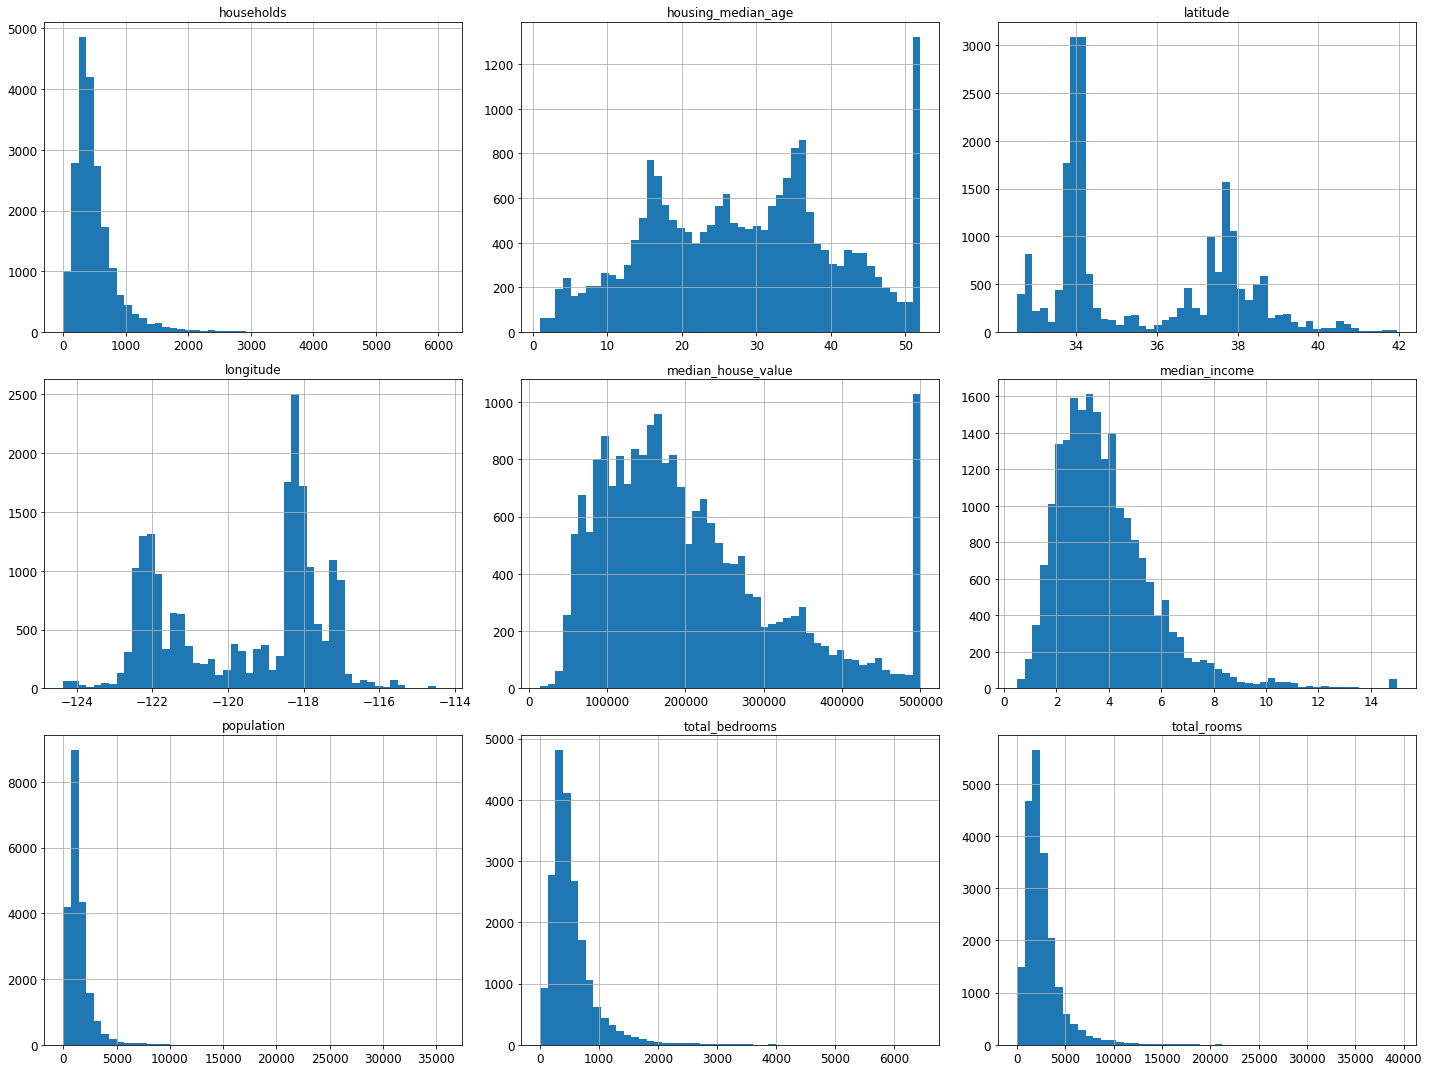

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

Notice a few things in these histograms:
1. First, the median income attribute does not look like it is expressed in US dollars
(USD). After checking with the team that collected the data, you are told that the
data has been scaled and capped at 15 (actually 15.0001) for higher median
incomes, and at 0.5 (actually 0.4999) for lower median incomes. Working with
preprocessed attributes is common in Machine Learning, and it is not necessarily
a problem, but you should try to understand how the data was computed.
2. The housing median age and the median house value were also capped (outlier at 500K$ or capped (not enough) data for the range in between)). 

The latter
may be a serious problem since it is your target attribute (your labels). Your
Machine Learning algorithms may learn that prices never go beyond that limit.
You need to check with your client team (the team that will use your system’s output)
to see if this is a problem or not. If they tell you that they need precise predictions
even beyond $500,000, then you have mainly two options:

a. Collect proper labels for the districts whose labels were capped.

b. Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond
$500,000).

3. These attributes have very different scales. We will discuss this later in this chapter when we explore feature scaling.

4. Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

Hopefully you now have a better understanding of the kind of data you are dealing with.

In [ ]:
# to make this notebook's output identical at every run
np.random.seed(42)

# Create a Test Set
It may sound strange to voluntarily set aside part of the data at this stage. After all,
you have only taken a quick glance at the data, and surely you should learn a whole
lot more about it before you decide what algorithms to use, right? This is true, but
your brain is an amazing pattern detection system, which means that it is highly
prone to overfitting: if you look at the test set, you may stumble upon some seemingly
interesting pattern in the test data that leads you to select a particular kind of
Machine Learning model. When you estimate the generalization error using the test
set, your estimate will be too optimistic and you will launch a system that will not
perform as well as expected. This is called data snooping bias.
Creating a test set is theoretically quite simple: just pick some instances randomly,
typically 20% of the dataset, and set them aside.

Well, this works, but it is not perfect: if you run the program again, it will generate a
different test set! Over time, you (or your Machine Learning algorithms) will get to
see the whole dataset, which is what you want to avoid.
One solution is to save the test set on the first run and then load it in subsequent
runs. Another option is to set the random number generator’s seed (e.g., np.ran
dom.seed(42))13 before calling np.random.permutation(), so that it always generates
the same shuffled indices.



In [ ]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


But both these solutions will break next time you fetch an updated dataset. A common
solution is to use each instance’s identifier to decide whether or not it should go
in the test set (assuming instances have a unique and immutable identifier). For
example, you could compute a hash of each instance’s identifier, keep only the last
byte of the hash, and put the instance in the test set if this value is lower or equal to
51 (~20% of 256). This ensures that the test set will remain consistent across multiple
runs, even if you refresh the dataset. The new test set will contain 20% of the new
instances, but it will not contain any instance that was previously in the training set.
Here is a possible implementation:

In [ ]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

The implementation of `test_set_check()` above works fine in both Python 2 and Python 3. In earlier releases, the following implementation was proposed, which supported any hash function, but was much slower and did not support Python 2:

In [ ]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

If you want an implementation that supports any hash function and is compatible with both Python 2 and Python 3, here is one:

In [ ]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

Unfortunately, the housing dataset does not have an identifier column. The simplest
solution is to use the row index as the ID:

In [ ]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data
gets appended to the end of the dataset, and no row ever gets deleted. If this is not
possible, then you can try to use the most stable features to build a unique identifier.
For example, a district’s latitude and longitude are guaranteed to be stable for a few
million years, so you could combine them into an ID like so:

In [ ]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [ ]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


# Feature extraction (derivation)

Suppose you chatted with experts who told you that the median income is a very
important attribute to predict median housing prices. You may want to ensure that
the test set is representative of the various categories of incomes in the whole dataset.
Since the median income is a continuous numerical attribute, you first need to create
an income category attribute. Let’s look at the median income histogram more closely

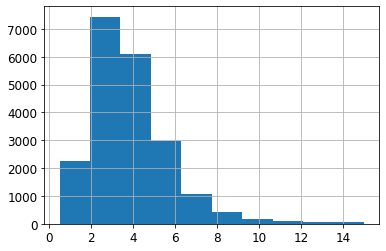

In [ ]:
housing["median_income"].hist()

**Warning**: in the book, I did not use `pd.cut()`, instead I used the code below. The `pd.cut()` solution gives the same result (except the labels are integers instead of floats), but it is simpler to understand:

```python
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
```

Most median income values are clustered around 2–5 (tens of thousands of dollars),
but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s
importance may be biased. This means that you should not have too many strata, and
each stratum should be large enough. The following code creates an income category
attribute by dividing the median income by 1.5 (to limit the number of income categories),
and rounding up using ceil (to have discrete categories), and then merging
all the categories greater than 5 into category 5:

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

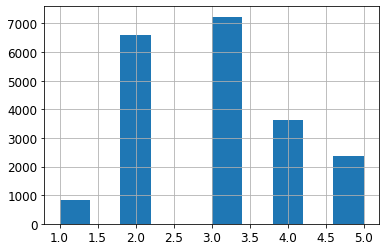

In [ ]:
housing["income_cat"].hist()

## Stratified sampling
So far we have considered purely random sampling methods. This is generally fine if
your dataset is large enough (especially relative to the number of attributes), but if it
is not, you run the risk of introducing a significant sampling bias. When a survey
company decides to call 1,000 people to ask them a few questions, they don’t just pick
1,000 people randomly in a phone booth. They try to ensure that these 1,000 people
are representative of the whole population. For example, the US population is composed
of 51.3% female and 48.7% male, so a well-conducted survey in the US would
try to maintain this ratio in the sample: 513 female and 487 male. This is called stratified
sampling: the population is divided into homogeneous subgroups called strata,
and the right number of instances is sampled from each stratum to guarantee that the
test set is representative of the overall population. If they used purely random sampling,
there would be about 12% chance of sampling a skewed test set with either less
than 49% female or more than 54% female. Either way, the survey results would be
significantly biased.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [ ]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [ ]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


You can measure the income category proportions in the test set.Table above compares the income category proportions in the overall dataset, in the
test set generated with stratified sampling, and in a test set generated using purely
random sampling. As you can see, the test set generated using stratified sampling has
income category proportions almost identical to those in the full dataset, whereas the
test set generated using purely random sampling is quite skewed.

Now you should remove the income_cat attribute so the data is back to its original
state:

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

We spent quite a bit of time on test set generation for a good reason: this is an often
neglected but critical part of a Machine Learning project. Moreover, many of these
ideas will be useful later when we discuss cross-validation. Now it’s time to move on
to the next stage: exploring the data.

# Discover and visualize the data to gain insights

So far you have only taken a quick glance at the data to get a general understanding of
the kind of data you are manipulating. Now the goal is to go a little bit more in depth.
First, make sure you have put the test set aside and you are only exploring the training
set. Also, if the training set is very large, you may want to sample an exploration
set, to make manipulations easy and fast. In our case, the set is quite small so you can
just work directly on the full set. Let’s create a copy so you can play with it without
harming the training set:

In [ ]:
housing = strat_train_set.copy()

NameError: ignored

# Visualizing Geographical Data
Since there is geographical information (latitude and longitude), it is a good idea to
create a scatterplot of all districts to visualize the data

Saving figure bad_visualization_plot


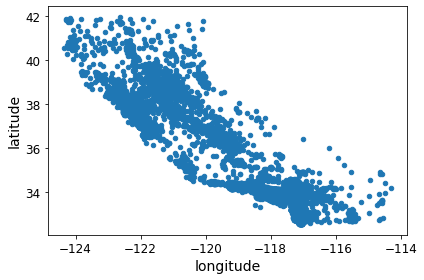

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

This looks like California all right, but other than that it is hard to see any particular
pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places
where there is a __high density of data points__

Saving figure better_visualization_plot


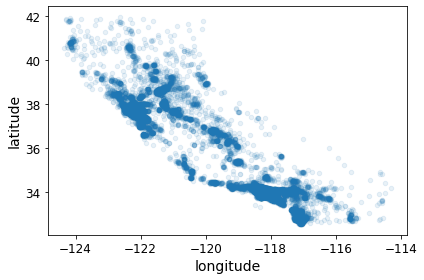

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Now that’s much better: you can clearly see the high-density areas, namely the Bay
Area and around Los Angeles and San Diego, plus a long line of fairly high density in
the Central Valley, in particular around Sacramento and Fresno.
More generally, our brains are very good at spotting patterns on pictures, but you
may need to play around with visualization parameters to make the patterns stand
out.
Now let’s look at the housing prices (Figure 2-13). The radius of each circle represents
the district’s population (option s), and the color represents the price (option c). We
will use a predefined color map (option cmap) called jet, which ranges from blue
(low values) to red (high prices):

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

Saving figure housing_prices_scatterplot


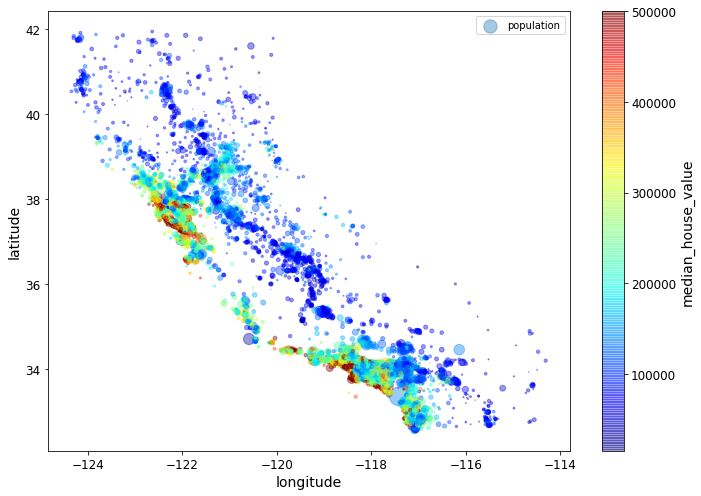

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

Saving figure california_housing_prices_plot


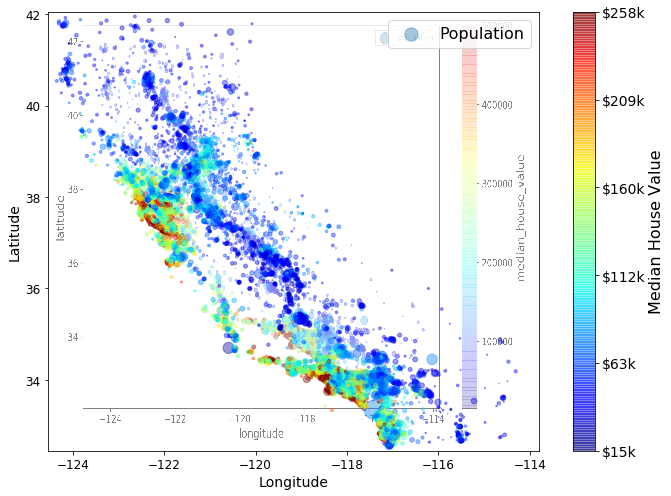

In [ ]:
'''
import matplotlib.image as mpimg
california_img=mpimg.imread('housing_prices_scatterplot.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()
'''

This image tells you that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density, as you probably knew already.
It will probably be useful to use a clustering algorithm to detect the main clusters, and
add new features that measure the proximity to the cluster centers. The ocean proximity
attribute may be useful as well, although in Northern California the housing
prices in coastal districts are not too high, so it is not a simple rule.

# Looking for Correlations
Since the dataset is not too large, you can easily compute the standard correlation
coefficient (also called Pearson’s r) between every pair of attributes using the corr()
method:

In [ ]:
corr_matrix = housing.corr()

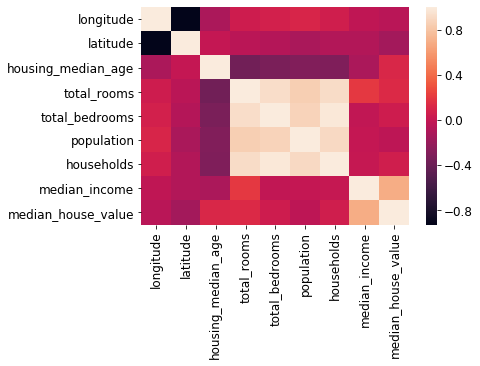

In [ ]:
import seaborn as sns

sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)

Now let’s look at how much each attribute correlates with the median house value:

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that
there is a strong positive correlation; for example, the median house value tends to go
up when the median income goes up. When the coefficient is close to –1, it means
that there is a strong negative correlation; you can see a small negative correlation
between the latitude and the median house value (i.e., prices have a slight tendency to
go down when you go north). Finally, coefficients close to zero mean that there is no
linear correlation.

__Note__

The correlation coefficient only measures linear correlations (“if x
goes up, then y generally goes up/down”). It may completely miss
out on nonlinear relationships (e.g., “if x is close to zero then y generally
goes up”). Note how all the plots of the bottom row have a
correlation coefficient equal to zero despite the fact that their axes
are clearly not independent: these are examples of nonlinear relationships.
Also, the second row shows examples where the correlation
coefficient is equal to 1 or –1; notice that this has nothing to
do with the slope. For example, your height in inches has a correlation
coefficient of 1 with your height in feet or in nanometers.

Another way to check for correlation between attributes is to use Pandas’
scatter_matrix function, which plots every numerical attribute against every other
numerical attribute. Since there are now 11 numerical attributes, you would get 11^2 = 121 plots, which would not fit on a page, so let’s just focus on a few promising
attributes that seem most correlated with the median housing value:

Saving figure scatter_matrix_plot


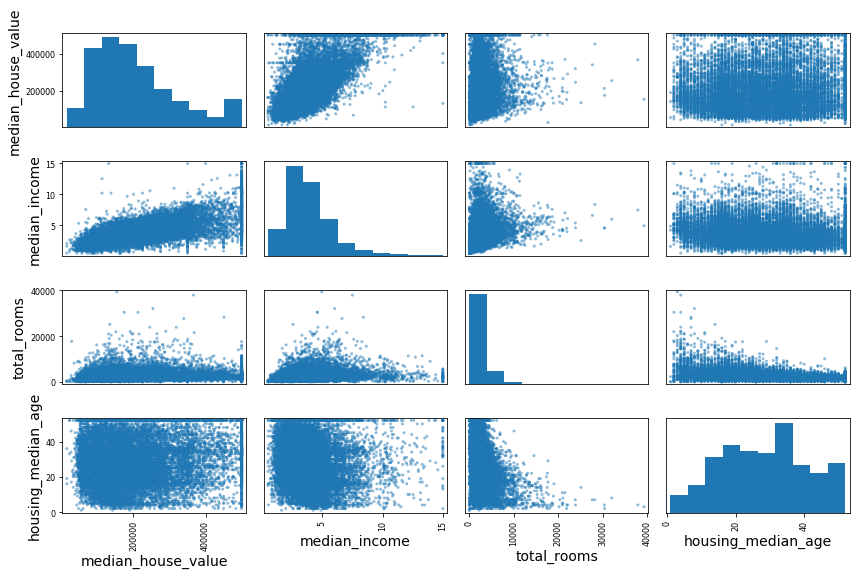

In [ ]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

The main diagonal (top left to bottom right) would be full of straight lines if Pandas
plotted each variable against itself, which would not be very useful. So instead Pandas
displays a histogram of each attribute (other options are available; see Pandas’ documentation
for more details).
The most promising attribute to predict the median house value is the median
income, so let’s zoom in on their correlation scatterplot:

Saving figure income_vs_house_value_scatterplot


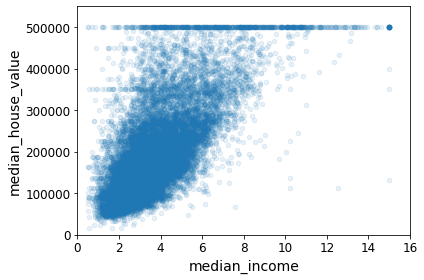

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

This plot reveals a few things. First, the correlation is indeed very strong; you can
clearly see the upward trend and the points are not too dispersed. Second, the price
cap that we noticed earlier is clearly visible as a horizontal line at 500,000. But this plot reveals other less obvious straight lines: a horizontal line around 450,000,
another around 350,000, perhaps one around 280,000, and a few more below that.
You may want to try removing the corresponding districts to prevent your algorithms
from learning to reproduce these data quirks.



Hopefully the previous sections gave you an idea of a few ways you can explore the
data and gain insights. You identified a few data quirks that you may want to clean up
before feeding the data to a Machine Learning algorithm, and you found interesting
correlations between attributes, in particular with the target attribute. 

__Skewed distributions__
You also noticed that some attributes have a tail-heavy distribution, so you may want to transform them (e.g., by computing their logarithm), __Why?__

Because, if a distribution is right skewed (most values are towards 0), then the large values range are almost as important as each others (they rarely occur, so you don't want to differentiate a lot 50K from 51K). So taking the log will encode almost linearly the small range, while it will compress all the large values to very near values. This is a common symptom in price variables for example. In other words, if most of my values are grouped in one side (say around 0), then I should focus to get these as precise as possible because this will get me the highest score, while the rare values can all be represented almost equally.

Of course, your mileage will vary considerably with each project, but the general ideas are similar.

# Experimenting with Attribute Combinations


__Another type of features extraction__

One last thing you may want to do before actually preparing the data for Machine
Learning algorithms is to try out various attribute combinations. For example, the
total number of rooms in a district is not very useful if you don’t know how many
households there are. What you really want is the number of rooms per household.
Similarly, the total number of bedrooms by itself is not very useful: you probably
want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new
attributes:

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

And now let’s look at the correlation matrix again:

Note: there was a bug in the previous cell, in the definition of the `rooms_per_household` attribute. This explains why the correlation value below differs slightly from the value in the book (unless you are reading the latest version).

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

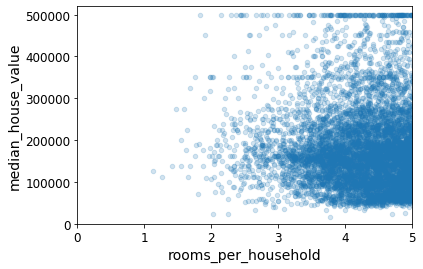

In [ ]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


Hey, not bad! The new bedrooms_per_room attribute is much more correlated with
the median house value than the total number of rooms or bedrooms. Apparently
houses with a lower bedroom/room ratio tend to be more expensive. The number of
rooms per household is also more informative than the total number of rooms in a
district—obviously the larger the houses, the more expensive they are.

This round of exploration does not have to be absolutely thorough; the point is to
start off on the right foot and quickly gain insights that will help you get a first reasonably
good prototype. But this is an iterative process: once you get a prototype up
and running, you can analyze its output to gain more insights and come back to this
exploration step.

# Prepare the data for Machine Learning algorithms

It’s time to prepare the data for your Machine Learning algorithms. Instead of just
doing this manually, you should write functions to do that, for several good reasons:

• This will allow you to reproduce these transformations easily on any dataset (e.g.,
the next time you get a fresh dataset).

• You will gradually build a library of transformation functions that you can reuse
in future projects.

• You can use these functions in your live system to transform the new data before feeding it to your algorithms.

• This will make it possible for you to easily try various transformations and see
which combination of transformations works best.

But first let’s revert to a clean training set (by copying strat_train_set once again),
and let’s separate the predictors and the labels since we don’t necessarily want to apply
the same transformations to the predictors and the target values __(note that drop() creates a copy of the data and does not affect strat_train_set)__:

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

# Data Cleaning
Most Machine Learning algorithms cannot work with missing features, so let’s create
a few functions to take care of them. You noticed earlier that the total_bedrooms
attribute has some missing values, so let’s fix this. You have three options:

• Get rid of the corresponding districts.

• Get rid of the whole attribute.

• Set the values to some value (zero, the mean, the median, etc.).

You can accomplish these easily using DataFrame’s dropna(), drop(), and fillna()
methods:


In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


If you choose option 3, you should compute the median value on the training set, and
use it to fill the missing values in the training set, but also don’t forget to save the
median value that you have computed. You will need it later to replace missing values
in the test set when you want to evaluate your system, and also once the system goes
live to replace missing values in new data.

It is not prefered to include the test data to compute that median (or stats in general), but you may do so __as long as you dont use the target variable__. But this is not preferred in general.

# Sklearn

Scikit-Learn’s API is remarkably well designed. The main design principles are:16
• Consistency. All objects share a consistent and simple interface:

—Estimators. Any object that can estimate some parameters based on a dataset
is called an estimator (e.g., an imputer is an estimator). The estimation itself is
performed by the fit() method, and it takes only a dataset as a parameter (or
two for supervised learning algorithms; the second dataset contains the
labels). Any other parameter needed to guide the estimation process is considered
a hyperparameter (such as an imputer’s strategy), and it must be set
as an instance variable (generally via a constructor parameter).

—Transformers. Some estimators (such as an imputer) can also transform a
dataset; these are called transformers. Once again, the API is quite simple: the
transformation is performed by the transform() method with the dataset to
transform as a parameter. It returns the transformed dataset. This transformation
generally relies on the learned parameters, as is the case for an imputer.
All transformers also have a convenience method called fit_transform()

that is equivalent to calling fit() and then transform() (but sometimes
fit_transform() is optimized and runs much faster).

—Predictors. Finally, some estimators are capable of making predictions given a
dataset; they are called predictors. For example, the LinearRegression model
in the previous chapter was a predictor: it predicted life satisfaction given a
country’s GDP per capita. A predictor has a predict() method that takes a
dataset of new instances and returns a dataset of corresponding predictions. It
also has a score() method that measures the quality of the predictions given
a test set (and the corresponding labels in the case of supervised learning
algorithms).17

• Inspection. All the estimator’s hyperparameters are accessible directly via public
instance variables (e.g., imputer.strategy), and all the estimator’s learned
parameters are also accessible via public instance variables with an underscore
suffix (e.g., imputer.statistics_).

• Nonproliferation of classes. Datasets are represented as NumPy arrays or SciPy
sparse matrices, instead of homemade classes. Hyperparameters are just regular
Python strings or numbers.

• Composition. Existing building blocks are reused as much as possible. For
example, it is easy to create a Pipeline estimator from an arbitrary sequence of
transformers followed by a final estimator, as we will see.

• Sensible defaults. Scikit-Learn provides reasonable default values for most
parameters, making it easy to create a baseline working system quickly.

__Imputer__

Scikit-Learn provides a handy class to take care of missing values: Imputer. Here is
how to use it. First, you need to create an Imputer instance, specifying that you want
to replace each attribute’s missing values with the median of that attribute:

**Warning**: Since Scikit-Learn 0.20, the `sklearn.preprocessing.Imputer` class was replaced by the `sklearn.impute.SimpleImputer` class.

In [ ]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

Since the median can only be computed on numerical attributes, we need to create a
copy of the data without the text attribute ocean_proximity:

Now you can fit the imputer instance to the training data using the fit() method:

In [ ]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

The imputer has simply computed the median of each attribute and stored the result
in its statistics_ instance variable. Only the total_bedrooms attribute had missing
values, but we cannot be sure that there won’t be any missing values in new data after
the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Check that this is the same as manually computing the median of each attribute:

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Transform the training set:

Now you can use this “trained” imputer to transform the training set by replacing
missing values by the learned medians:

In [ ]:
X = imputer.transform(housing_num)

The result is a plain Numpy array containing the transformed features. If you want to
put it back into a Pandas DataFrame, it’s simple:

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [ ]:
imputer.strategy

'median'

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


# Handling Text and Categorical Attributes
Earlier we left out the categorical attribute ocean_proximity because it is a text
attribute so we cannot compute its median. Most Machine Learning algorithms prefer
to work with numbers anyway, so let’s convert these text labels to numbers.
Scikit-Learn provides a transformer for this task called LabelEncoder:

Now let's preprocess the categorical input feature, `ocean_proximity`:

**Warning**: earlier versions of the book used the `LabelEncoder` class or Pandas' `Series.factorize()` method to encode string categorical attributes as integers. However, the `OrdinalEncoder` class that was introduced in Scikit-Learn 0.20 (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)) is preferable since it is designed for input features (`X` instead of labels `y`) and it plays well with pipelines (introduced later in this notebook). If you are using an older version of Scikit-Learn (<0.20), then you can import it from `future_encoders.py` instead.

This is better: now we can use this numerical data in any ML algorithm. You can look
at the mapping that this encoder has learned using the classes_ attribute (“<1H
OCEAN” is mapped to 0, “INLAND” is mapped to 1, etc.):

In [ ]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [ ]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# One Hot Encoder
One issue with this representation is that ML algorithms will assume that two nearby
values are more similar than two distant values. Obviously this is not the case (for
example, categories 0 and 4 are more similar than categories 0 and 1). 


To fix this issue, a common solution is to create one binary attribute per category: one attribute
equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute
equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is
called one-hot encoding, because only one attribute will be equal to 1 (hot), while the
others will be 0 (cold).
Scikit-Learn provides a OneHotEncoder encoder to convert integer categorical values
into one-hot vectors. Let’s encode the categories as one-hot vectors. 

Note that
fit_transform() expects a 2D array, but housing_cat_encoded is a 1D array, so we
need to reshape it:

**Warning**: earlier versions of the book used the `LabelBinarizer` or `CategoricalEncoder` classes to convert each categorical value to a one-hot vector. It is now preferable to use the `OneHotEncoder` class. Since Scikit-Learn 0.20 it can handle string categorical inputs (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)), not just integer categorical inputs. If you are using an older version of Scikit-Learn, you can import the new version from `future_encoders.py`:

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very
useful when you have categorical attributes with thousands of categories. After onehot
encoding we get a matrix with thousands of columns, and the matrix is full of
zeros except for one 1 per row. Using up tons of memory mostly to store zeros would
be very wasteful, so instead a sparse matrix only stores the location of the nonzero
elements. You can use it mostly like a normal 2D array,19 but if you really want to convert
it to a (dense) NumPy array, just call the toarray() method:

In [ ]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Let's create a custom transformer to add extra attributes:

# Custom Transformers
Although Scikit-Learn provides many useful transformers, you will need to write
your own for tasks such as custom cleanup operations or combining specific
attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities
(such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance),
all you need is to create a class and implement three methods: fit()
(returning self), transform(), and fit_transform(). You can get the last one for
free by simply adding TransformerMixin as a base class. Also, if you add BaseEstima
tor as a base class (and avoid *args and **kargs in your constructor) you will get
two extra methods (get_params() and set_params()) that will be useful for automatic
hyperparameter tuning. For example, here is a small transformer class that adds
the combined attributes we discussed earlier:

In [ ]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Alternatively, you can use Scikit-Learn's `FunctionTransformer` class that lets you easily create a transformer based on a transformation function (thanks to [Hanmin Qin](https://github.com/qinhanmin2014) for suggesting this code). Note that we need to set `validate=False` because the data contains non-float values (`validate` will default to `False` in Scikit-Learn 0.22).

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In this example the transformer has one hyperparameter, add_bedrooms_per_room,
set to True by default (it is often helpful to provide sensible defaults). This hyperparameter
will allow you to easily find out whether adding this attribute helps the
Machine Learning algorithms or not. 

More generally, you can add a hyperparameter
to gate any data preparation step that you are not 100% sure about. The more you
automate these data preparation steps, the more combinations you can automatically
try out, making it much more likely that you will find a great combination (and saving
you a lot of time).

# Feature Scaling
One of the most important transformations you need to apply to your data is feature
scaling. With few exceptions, Machine Learning algorithms don’t perform well when
the input numerical attributes have very different scales. This is the case for the housing
data: the total number of rooms ranges from about 6 to 39,320, while the median
incomes only range from 0 to 15. Note that scaling the target values is generally not
required.
There are two common ways to get all attributes to have the same scale: min-max
scaling and standardization.


Min-max scaling (many people call this normalization) is quite simple: values are
shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting
the min value and dividing by the max minus the min. Scikit-Learn provides a
transformer called MinMaxScaler for this. It has a feature_range hyperparameter
that lets you change the range if you don’t want 0–1 for some reason.


Standardization is quite different: first it subtracts the mean value (so standardized
values always have a zero mean), and then it divides by the variance so that the resulting
distribution has unit variance. Unlike min-max scaling, standardization does not
bound values to a specific range, which may be a problem for some algorithms (e.g.,
neural networks often expect an input value ranging from 0 to 1). However, standardization
is much less affected by outliers. For example, suppose a district had a median
income equal to 100 (by mistake). Min-max scaling would then crush all the other
values from 0–15 down to 0–0.15, whereas standardization would not be much affected.


Scikit-Learn provides a transformer called StandardScaler for standardization.

# Transformation Pipelines
As you can see, there are many data transformation steps that need to be executed in
the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with
such sequences of transformations. Here is a small pipeline for the numerical
attributes:

Now let's build a pipeline for preprocessing the numerical attributes (note that we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

**Warning**: earlier versions of the book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). 

It is now preferable to use the `ColumnTransformer` class that was introduced in Scikit-Learn 0.20. If you are using an older version of Scikit-Learn, you can import it from `future_encoders.py`:

In [ ]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
housing_prepared.shape

(16512, 16)

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features (again, we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

The Pipeline constructor takes a list of name/estimator pairs defining a sequence of
steps. All but the last estimator must be transformers (i.e., they must have a
fit_transform() method). The names can be anything you like.
When you call the pipeline’s fit() method, it calls fit_transform() sequentially on
all transformers, passing the output of each call as the parameter to the next call, until
it reaches the final estimator, for which it just calls the fit() method.
The pipeline exposes the same methods as the final estimator. In this example, the last
estimator is a StandardScaler, which is a transformer, so the pipeline has a trans
form() method that applies all the transforms to the data in sequence (it also has a
fit_transform method that we could have used instead of calling fit() and then
transform()).

# Feature Union

You now have a pipeline for numerical values, and you also need to apply the LabelBi
narizer on the categorical values: how can you join these transformations into a single
pipeline? Scikit-Learn provides a FeatureUnion class for this. You give it a list of
transformers (which can be entire transformer pipelines), and when its transform()
method is called it runs each transformer’s transform() method in parallel, waits for
their output, and then concatenates them and returns the result (and of course calling
its fit() method calls all each transformer’s fit() method). A full pipeline handling
both numerical and categorical attributes may look like this:

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

And you can run the whole pipeline simply:


In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Select and train a model 

At last! You framed the problem, you got the data and explored it, you sampled a
training set and a test set, and you wrote transformation pipelines to clean up and
prepare your data for Machine Learning algorithms automatically. You are now ready
to select and train a Machine Learning model.

# Training and Evaluating on the Training Set
The good news is that thanks to all these previous steps, things are now going to be
much simpler than you might think. Let’s first train a Linear Regression model, like we did in the previous chapter:

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Done! You now have a working Linear Regression model. Let’s try it out on a few
instances from the training set:

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

It works, although the predictions are not exactly accurate (e.g., the second prediction
is off by more than 50%!). Let’s measure this regression model’s RMSE on the whole
training set using Scikit-Learn’s mean_squared_error function:

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

Okay, this is better than nothing but clearly not a great score: most districts’
median_housing_values range between $120,000 and $265,000, so a typical prediction
error of $68,628 is not very satisfying. This is an example of a model underfitting
the training data. When this happens it can mean that the features do not provide
enough information to make good predictions, or that the model is not powerful
enough. As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or
to reduce the constraints on the model. This model is not regularized, so this rules
out the last option. You could try to add more features (e.g., the log of the population),
but first let’s try a more complex model to see how it does.
Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding
complex nonlinear relationships in the data (Decision Trees are presented more later). The code should look familiar by now:

# Fine-tune your model

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Now that the model is trained, let’s evaluate it on the training set:

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course,
it is much more likely that the model has badly overfit the data. How can you be sure?
As we saw earlier, you don’t want to touch the test set until you are ready to launch a
model you are confident about, so you need to use part of the training set for training,
and part for model validation.

# Extra

Better Evaluation Using Cross-Validation
One way to evaluate the Decision Tree model would be to use the train_test_split
function to split the training set into a smaller training set and a validation set, then
train your models against the smaller training set and evaluate them against the validation
set. It’s a bit of work, but nothing too difficult and it would work fairly well.
A great alternative is to use Scikit-Learn’s cross-validation feature. The following code
performs K-fold cross-validation: it randomly splits the training set into 10 distinct
subsets called folds, then it trains and evaluates the Decision Tree model 10 times,
picking a different fold for evaluation every time and training on the other 9 folds.
The result is an array containing the 10 evaluation scores:

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

Scikit-Learn cross-validation features expect a utility function
(greater is better) rather than a cost function (lower is better), so
the scoring function is actually the opposite of the MSE (i.e., a negative
value), which is why the preceding code computes -scores
before calculating the square root.

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform
worse than the Linear Regression model! Notice that cross-validation allows
you to get not only an estimate of the performance of your model, but also a measure
of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a
score of approximately 71,200, generally ±3,200. You would not have this information
if you just used one validation set. But cross-validation comes at the cost of training
the model several times, so it is not always possible.
Let’s compute the same scores for the Linear Regression model just to be sure:

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


That’s right: the Decision Tree model is overfitting so badly that it performs worse
than the Linear Regression model.

Let’s try one last model now: the RandomForestRegressor. As we will see in later, Random Forests work by training many Decision Trees on random subsets of
the features, then averaging out their predictions. Building a model on top of many
other models is called Ensemble Learning, and it is often a great way to push ML algorithms
even further. We will skip most of the code since it is essentially the same as
for the other models:

**Note**: we specify `n_estimators=10` to avoid a warning about the fact that the default value is going to change to 100 in Scikit-Learn 0.22.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

Wow, this is much better: Random Forests look very promising. However, note that
the score on the training set is still much lower than on the validation sets, meaning
that the model is still overfitting the training set. Possible solutions for overfitting are
to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.

__However, before you dive much deeper in Random Forests, you should try out many other models from various categories of Machine Learning algorithms (several Support Vector Machines with different kernels, possibly a neural network, etc.), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.__

You should save every model you experiment with, so you can
come back easily to any model you want. Make sure you save both
the hyperparameters and the trained parameters, as well as the
cross-validation scores and perhaps the actual predictions as well.
This will allow you to easily compare scores across model types,
and compare the types of errors they make. You can easily save
Scikit-Learn models by using Python’s pickle module, or using
sklearn.externals.joblib, which is more efficient at serializing
large NumPy arrays:

```
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")
```

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

# Fine-Tune Your Model
Let’s assume that you now have a shortlist of promising models. You now need to
fine-tune them. Let’s look at a few ways you can do that.

# Grid Search
One way to do that would be to fiddle with the hyperparameters manually, until you
find a great combination of hyperparameter values. This would be very tedious work,
and you may not have time to explore many combinations.
Instead you should get Scikit-Learn’s GridSearchCV to search for you. All you need to
do is tell it which hyperparameters you want it to experiment with, and what values to
try out, and it will evaluate all the possible combinations of hyperparameter values,
using cross-validation. For example, the following code searches for the best combination
of hyperparameter values for the RandomForestRegressor:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

When you have no idea what value a hyperparameter should have,
a simple approach is to try out consecutive powers of 10 (or a
smaller number if you want a more fine-grained search, as shown
in this example with the n_estimators hyperparameter).

The best hyperparameter combination found:

This param_grid tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of
n_estimators and max_features hyperparameter values specified in the first dict
(don’t worry about what these hyperparameters mean for now; they will be explained
in Chapter 7), then try all 2 × 3 = 6 combinations of hyperparameter values in the
second dict, but this time with the bootstrap hyperparameter set to False instead of
True (which is the default value for this hyperparameter).
All in all, the grid search will explore 12 + 6 = 18 combinations of RandomForestRe
gressor hyperparameter values, and it will train each model five times (since we are
using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90
rounds of training! It may take quite a long time, but when it is done you can get the
best combination of parameters like this:



In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

You can also get the best estimator directly:

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

If GridSearchCV is initialized with refit=True (which is the
default), then once it finds the best estimator using crossvalidation,
it retrains it on the whole training set. This is usually a
good idea since feeding it more data will likely improve its performance.

And of course the evaluation scores are also available:

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.070716,0.001160,0.004835,0.000199,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,-4.196408e+09,-3.903319e+09,-4.184325e+09,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.236999,0.012149,0.014101,0.000906,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,-3.130196e+09,-2.865188e+09,-3.173856e+09,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.701290,0.010494,0.038948,0.003121,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,-2.948330e+09,-2.619995e+09,-2.970968e+09,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.117287,0.002343,0.005573,0.000625,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,-3.734515e+09,-3.418747e+09,-3.913907e+09,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.381003,0.006049,0.014784,0.001137,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,-2.892276e+09,-2.616813e+09,-2.948207e+09,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.123637,0.010225,0.040625,0.001504,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,-2.666426e+09,-2.398071e+09,-2.649316e+09,-2.537877e+09,1.214603e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.152212,0.005726,0.005664,0.000420,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,-3.592772e+09,-3.328934e+09,-3.579607e+09,-3.441447e+09,1.893141e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.506308,0.004494,0.014492,0.000476,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,-2.762720e+09,-2.521134e+09,-2.907667e+09,-2.704640e+09,1.471542e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.568237,0.008729,0.041293,0.001727,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,-2.607703e+09,-2.350953e+09,-2.661059e+09,-2.514668e+09,1.285063e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.196806,0.003244,0.005423,0.000718,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,-3.402843e+09,-3.129307e+09,-3.510047e+09,-3.348851e+09,1.241864e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


In this example, we obtain the best solution by setting the max_features hyperparameter
to 6, and the n_estimators hyperparameter to 30. The RMSE score for this
combination is 49,959, which is slightly better than the score you got earlier using the default hyperparameter values (which was 52,634). Congratulations, you have successfully
fine-tuned your best model!

Don’t forget that you can treat some of the data preparation steps as
hyperparameters. For example, the grid search will automatically
find out whether or not to add a feature you were not sure about
(e.g., using the add_bedrooms_per_room hyperparameter of your
CombinedAttributesAdder transformer). It may similarly be used
to automatically find the best way to handle outliers, missing features,
feature selection, and more.

# Randomized Search
The grid search approach is fine when you are exploring relatively few combinations,
like in the previous example, but when the hyperparameter search space is large, it is
often preferable to use RandomizedSearchCV instead. This class can be used in much
the same way as the GridSearchCV class, but instead of trying out all possible combinations,
it evaluates a given number of random combinations by selecting a random
value for each hyperparameter at every iteration. This approach has two main benefits:

• If you let the randomized search run for, say, 1,000 iterations, this approach will
explore 1,000 different values for each hyperparameter (instead of just a few values
per hyperparameter with the grid search approach).


• You have more control over the computing budget you want to allocate to hyperparameter
search, simply by setting the number of iterations.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


# Ensemble Methods
Another way to fine-tune your system is to try to combine the models that perform
best. The group (or “ensemble”) will often perform better than the best individual
model (just like Random Forests perform better than the individual Decision Trees
they rely on), especially if the individual models make very different types of errors.
We will cover this topic in more detail later.
#Analyze the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For
example, the RandomForestRegressor can indicate the relative importance of each
attribute for making accurate predictions:

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features
(e.g., apparently only one ocean_proximity category is really useful, so you could try
dropping the others).
You should also look at the specific errors that your system makes, then try to understand
why it makes them and what could fix the problem (adding extra features or, on
the contrary, getting rid of uninformative ones, cleaning up outliers, etc.).

# Evaluate Your System on the Test Set
After tweaking your models for a while, you eventually have a system that performs
sufficiently well. Now is the time to evaluate the final model on the test set. There is
nothing special about this process; just get the predictors and the labels from your
test set, run your full_pipeline to transform the data (call transform(), not
fit_transform()!), and evaluate the final model on the test set:

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

47730.22690385927

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

We could compute the interval manually like this:

In [ ]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776, 49691.25001877858)

Alternatively, we could use a z-scores rather than t-scores:

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136455, 49690.68623889413)

The performance will usually be slightly worse than what you measured using crossvalidation
if you did a lot of hyperparameter tuning (because your system ends up
fine-tuned to perform well on the validation data, and will likely not perform as well
on unknown datasets). It is not the case in this example, but when this happens you
must resist the temptation to tweak the hyperparameters to make the numbers look
good on the test set; the improvements would be unlikely to generalize to new data.

Now comes the project prelaunch phase: you need to present your solution (highlighting
what you have learned, what worked and what did not, what assumptions
were made, and what your system’s limitations are), document everything, and create
nice presentations with clear visualizations and easy-to-remember statements (e.g.,
“the median income is the number one predictor of housing prices”).
# Launch, Monitor, and Maintain Your System
Perfect, you got approval to launch! You need to get your solution ready for production,
in particular by plugging the production input data sources into your system
and writing tests.
You also need to write monitoring code to check your system’s live performance at
regular intervals and trigger alerts when it drops. This is important to catch not only
sudden breakage, but also performance degradation. This is quite common because
models tend to “rot” as data evolves over time, unless the models are regularly trained
on fresh data.
Evaluating your system’s performance will require sampling the system’s predictions
and evaluating them. This will generally require a human analysis. These analysts
may be field experts, or workers on a crowdsourcing platform (such as Amazon
Mechanical Turk or CrowdFlower). Either way, you need to plug the human evaluation
pipeline into your system.
You should also make sure you evaluate the system’s input data quality. Sometimes
performance will degrade slightly because of a poor quality signal (e.g., a malfunctioning
sensor sending random values, or another team’s output becoming stale), but
it may take a while before your system’s performance degrades enough to trigger an
alert. If you monitor your system’s inputs, you may catch this earlier. Monitoring the
inputs is particularly important for online learning systems.
Finally, you will generally want to train your models on a regular basis using fresh
data. You should automate this process as much as possible. If you don’t, you are very likely to refresh your model only every six months (at best), and your system’s performance
may fluctuate severely over time. If your system is an online learning system,
you should make sure you save snapshots of its state at regular intervals so you can
easily roll back to a previously working state.
# Try It Out!
Hopefully this chapter gave you a good idea of what a Machine Learning project
looks like, and showed you some of the tools you can use to train a great system. As
you can see, much of the work is in the data preparation step, building monitoring
tools, setting up human evaluation pipelines, and automating regular model training.
The Machine Learning algorithms are also important, of course, but it is probably
preferable to be comfortable with the overall process and know three or four algorithms
well rather than to spend all your time exploring advanced algorithms and not
enough time on the overall process.
So, if you have not already done so, now is a good time to pick up a laptop, select a
dataset that you are interested in, and try to go through the whole process from A to
Z. 

# Kaggle 
A good place to start is on a competition website such as http://kaggle.com/: you
will have a dataset to play with, a clear goal, and people to share the experience with.

# Exercises
Using this chapter’s housing dataset:
1. Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters
such as kernel="linear" (with various values for the C hyperparameter)
or kernel="rbf" (with various values for the C and gamma
hyperparameters). Don’t worry about what these hyperparameters mean for now.
How does the best SVR predictor perform?
2. Try replacing GridSearchCV with RandomizedSearchCV.
3. Try adding a transformer in the preparation pipeline to select only the most
important attributes.
4. Try creating a single pipeline that does the full data preparation plus the final
prediction.
5. Automatically explore some preparation options using GridSearchCV.

# Extra material

## A full pipeline with both preparation and prediction

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## Model persistence using joblib

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Example SciPy distributions for `RandomizedSearchCV`

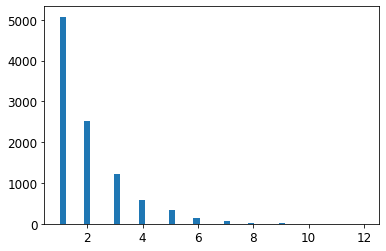

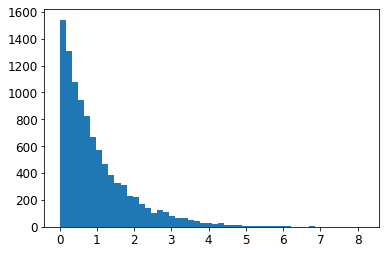

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 26.1min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 42.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=4,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.90313964167

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [ ]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  5.8min


The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [ ]:
rnd_search.best_params_

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [ ]:
k = 5

Now let's look for the indices of the top k features:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

Let's double check that these are indeed the top k features:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [ ]:
housing_prepared_top_k_features[0:3]

Now let's double check that these are indeed the top k features:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_

The best imputer strategy is `most_frequent` and apparently almost all features are useful (15 out of 16). The last one (`ISLAND`) seems to just add some noise.

Congratulations! You already know quite a lot about Machine Learning. :)